# FIG. 1. Using OpenStreetMap (OSM) to extract the road network

In [1]:
import osmnx as ox
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import sys
import warnings

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


fontsize = 24
if sys.platform != "darwn":
    pgf_with_latex = {  # setup matplotlib to use latex for output
        "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
        "text.usetex": True,  # use LaTeX to write all text
        "font.family": "serif",
        "font.serif": [],  # blank entries should cause plots
        "font.sans-serif": [],  # to inherit fonts from the document
        "font.monospace": [],
        "axes.labelsize": fontsize,  # LaTeX default is 10pt font.
        "font.size": fontsize,
        "legend.fontsize": fontsize,  # Make the legend/label fonts
        "xtick.labelsize": fontsize,  # a little smaller
        "ytick.labelsize": fontsize,
        "figure.figsize": (20, 12),  # default fig size of 0.9 textwidth
        "pgf.preamble": "\n".join(
            [  # plots will use this preamble
                r"\usepackage[utf8]{inputenc}",
                r"\usepackage[T1]{fontenc}",
            ]
        ),
    }
    mpl.rcParams.update(pgf_with_latex)


import src.FloodModule as fm
import src.RoadNetwork as rn
import src.PopulationFromRaster as pfr
import src.SupportFunctions as sf


### Building a RoadNetwork from a bounding box. Removing all roads that are in the flooded region. Adding the emergency services "hospital" and "fire_station" to the Nodes.

In [2]:
west, east = 6.65, 7.4
south, north = 50.25, 50.75

driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

region = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    bbox=[north, south, west, east],
)
region.add_pois("amenity", "hospital")
G = region.graph

flood = fm.flood_footprint()

flooded_roads = fm.flooded_roads(G, flood)
Gr = rn.remove_edges(G, flooded_roads.index)


num(nodes)= 32253
num(edges)= 76950


/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


### Setting the CRS and computing the Voronoi regions of the nodes

In [3]:
request = cimgt.OSM()
crs = ccrs.GOOGLE_MERCATOR

nodes, edges = ox.graph_to_gdfs(Gr)

crs_proj4 = crs.proj4_init
proj_nodes = nodes.to_crs(crs_proj4)
proj_edges = edges.to_crs(crs_proj4)
region.nodes = sf.voronoi_region_of_nodes(region.nodes)


### Creating the Figure

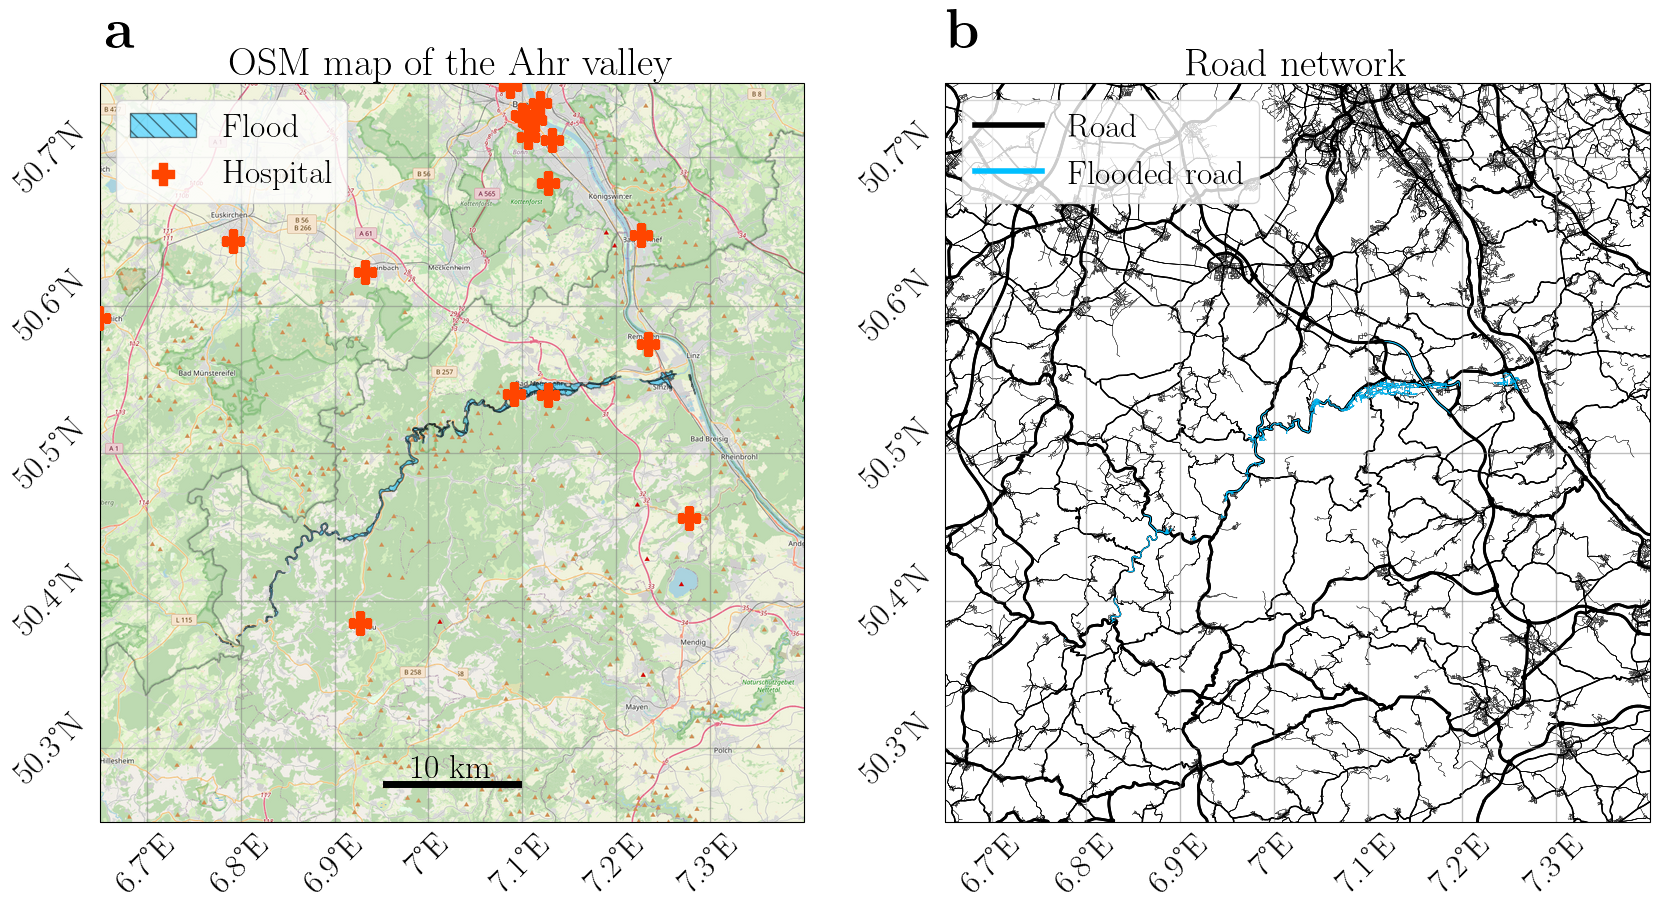

In [4]:
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={"projection": crs})


axs[0].set_title("OSM map of the Ahr valley")
axs[0].text(
    0.05,
    1.1,
    r"\textbf{a}",
    transform=axs[0].transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)


axs[1].set_title("Road network")
axs[1].text(
    0.05,
    1.1,
    r"\textbf{b}",
    transform=axs[1].transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)


axs[0].set_extent([west, east, south, north], crs=ccrs.PlateCarree())
tile_image = axs[0].add_image(request, 11, interpolation="spline36")

gl = axs[0].gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="-",
)

gl.xlabel_style = {"rotation": 45}
gl.ylabel_style = {"rotation": 45}

gpd.GeoSeries(flood).set_crs(region.edges.crs).to_crs(crs_proj4).plot(
    ax=axs[0], color="deepskyblue", zorder=1, hatch="\\\\", alpha=0.5, edgecolor="black"
)
sf.scale_bar(axs[0], 10, location=(0.5, 0.05), linewidth=5)

hosp_marker = sf.marker_from_svg("data/icons/hospital-14.svg")
proj_nodes[proj_nodes["amenity"] == "hospital"].plot(
    ax=axs[0], marker="P", markersize=250, color="orangered", zorder=4
)


poly_patch = mpatches.Patch(
    facecolor="deepskyblue", hatch="\\\\", label="Flood", alpha=0.5, edgecolor="black"
)

hosp = axs[0].scatter([], [], marker="P", color="orangered", s=250, label="Hospital")
axs[0].legend(handles=[poly_patch, hosp], loc="upper left")


###################################################################'

prim = ["motorway", "trunk", "primary", "motorway_link", "trunk_link", "primary_link"]
prim_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in prim)]
sec = ["secondary", "secondary_link"]
sec_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in sec)]
tert = ["tertiary", "tertiary_link"]
tert_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in tert)]

c = "black"
proj_edges.plot(ax=axs[1], color=c, linewidth=0.25, zorder=0)
tert_edg.plot(ax=axs[1], color=c, linewidth=0.5, zorder=0)
sec_edg.plot(ax=axs[1], color=c, linewidth=1, zorder=0, label="Road")
prim_edg.plot(ax=axs[1], color=c, linewidth=2, zorder=0)
proj_edges[proj_edges["removed"] == True].plot(
    ax=axs[1], color="deepskyblue", label="Flooded road", linewidth=0.5
)

gl = axs[1].gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="-",
)

gl.xlabel_style = {"rotation": 45}
gl.ylabel_style = {"rotation": 45}


axs[1].set_extent([west, east, south, north], crs=ccrs.PlateCarree())


roads = mlines.Line2D([], [], color="black", label="Road", linewidth=4)
froads = mlines.Line2D([], [], color="deepskyblue", label="Flooded road", linewidth=4)

axs[1].legend(handles=[roads, froads], loc="upper left")


In [34]:
fig.savefig("results/figs/FIG1-OSM-to-graph.png", bbox_inches="tight")
